Device: cuda
📂 Loading DREAMER dataset (dual spectrograms) from: C:\Users\akash\Downloads\DREAMER.mat
✅ Built dual spectrogram dataset: (414, 14, 36, 32) (414, 14, 36, 32)

--- Training Baseline Aware ConvNeXt Transformer for Valence (Single Fold)
Valence (Single Fold) TRAIN median threshold = 3.0000
Train class counts: [257 405] Val class counts: [33 50] Test class counts: [32 51]
Stage1 Ep1/6 loss 0.7162
Stage1 Ep2/6 loss 0.7010
Stage1 Ep3/6 loss 0.6910
Stage1 Ep4/6 loss 0.6997
Stage1 Ep5/6 loss 0.6945
Stage1 Ep6/6 loss 0.6958
Ep1/80 | Loss=0.5513 | Val Acc=39.76% | Prec=0.000 | Rec=0.000 | F1=0.000 | AUC=0.595
Ep2/80 | Loss=0.5488 | Val Acc=39.76% | Prec=0.000 | Rec=0.000 | F1=0.000 | AUC=0.605
Ep3/80 | Loss=0.5231 | Val Acc=45.78% | Prec=0.857 | Rec=0.120 | F1=0.211 | AUC=0.687
Ep4/80 | Loss=0.4772 | Val Acc=73.49% | Prec=0.741 | Rec=0.860 | F1=0.796 | AUC=0.718
Ep5/80 | Loss=0.4272 | Val Acc=71.08% | Prec=0.861 | Rec=0.620 | F1=0.721 | AUC=0.835
Ep6/80 | Loss=0.3554 | Val Acc=84.3

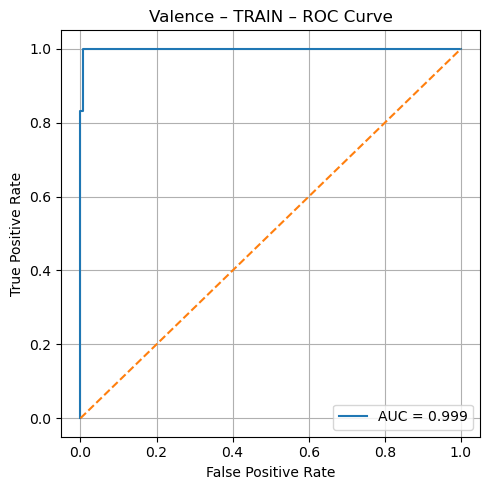

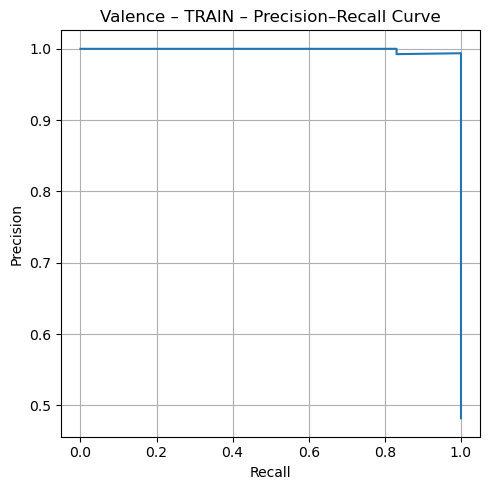

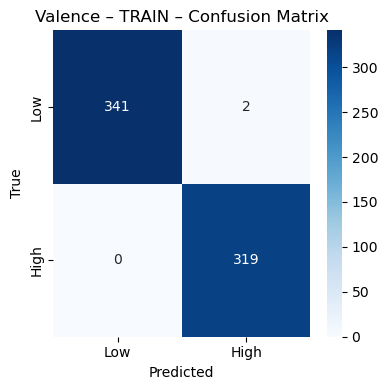


================ VALENCE – VALIDATION =================
Samples        : 83
Precision      : 0.9800
Recall         : 0.9800
F1-score       : 0.9800
AUC            : 0.9770
Cohen's Kappa  : 0.9497


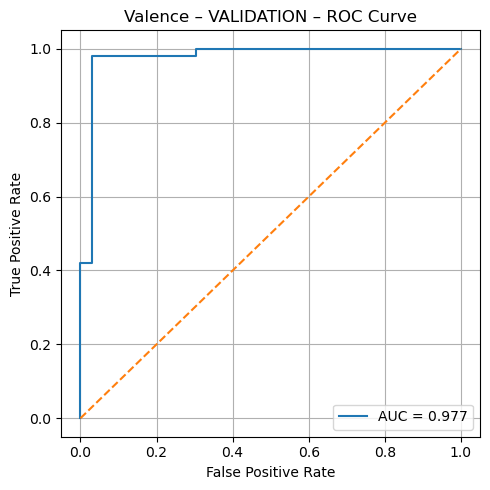

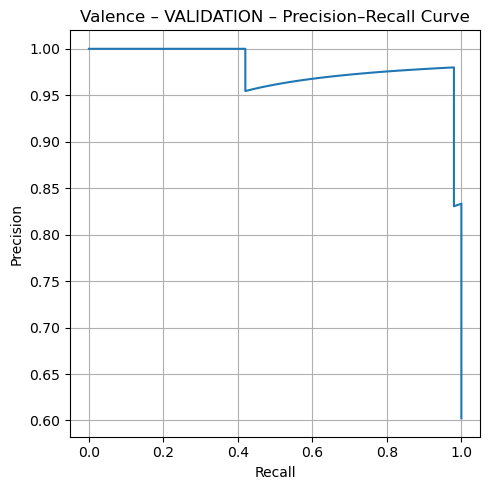

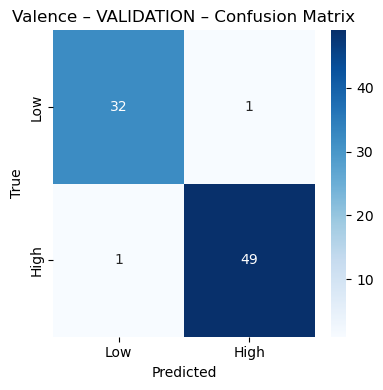


================ VALENCE – TEST =================
Samples        : 83
Precision      : 1.0000
Recall         : 0.8039
F1-score       : 0.8913
AUC            : 0.9657
Cohen's Kappa  : 0.7597


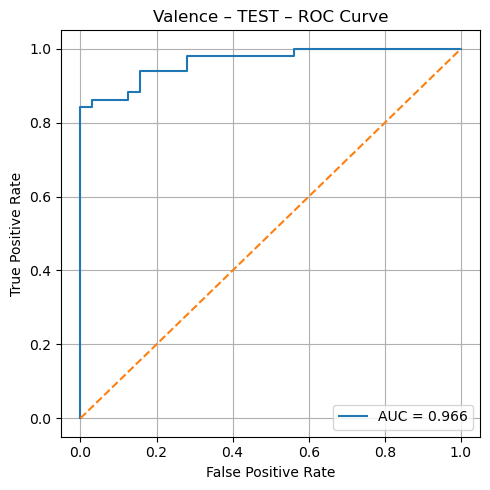

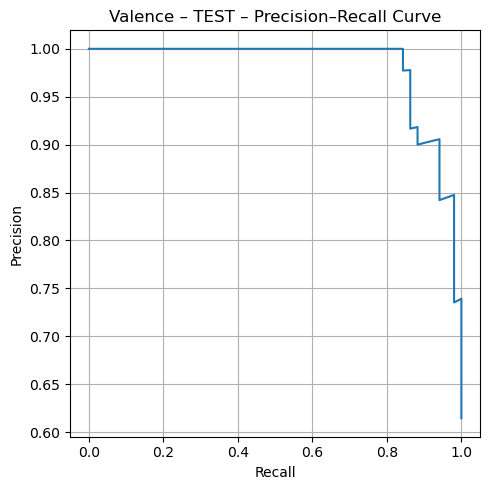

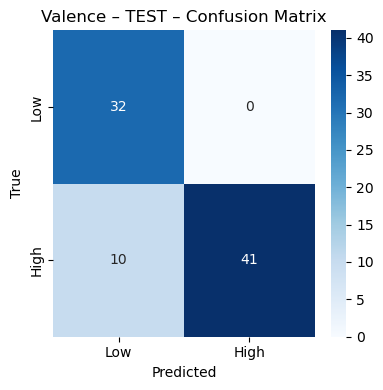


--- Training Baseline Aware ConvNeXt Transformer for Arousal (Single Fold) (AROUSAL)
Arousal (Single Fold) TRAIN median threshold = 3.0000
Train class counts: [182 480] Val class counts: [23 60] Test class counts: [23 60]
Stage1 Ep1/6 loss 0.6982
Stage1 Ep2/6 loss 0.7103
Stage1 Ep3/6 loss 0.7030
Stage1 Ep4/6 loss 0.7030
Stage1 Ep5/6 loss 0.7039
Stage1 Ep6/6 loss 0.6967
Ep1/80 | Loss=0.4291 | Val Acc=27.71% | Prec=0.000 | Rec=0.000 | F1=0.000 | AUC=0.483
Ep2/80 | Loss=0.4086 | Val Acc=27.71% | Prec=0.000 | Rec=0.000 | F1=0.000 | AUC=0.601
Ep3/80 | Loss=0.4091 | Val Acc=27.71% | Prec=0.000 | Rec=0.000 | F1=0.000 | AUC=0.550
Ep4/80 | Loss=0.4080 | Val Acc=27.71% | Prec=0.000 | Rec=0.000 | F1=0.000 | AUC=0.511
Ep5/80 | Loss=0.4118 | Val Acc=27.71% | Prec=0.000 | Rec=0.000 | F1=0.000 | AUC=0.504
Ep6/80 | Loss=0.4095 | Val Acc=27.71% | Prec=0.000 | Rec=0.000 | F1=0.000 | AUC=0.662
Ep7/80 | Loss=0.3750 | Val Acc=27.71% | Prec=0.000 | Rec=0.000 | F1=0.000 | AUC=0.829
Ep8/80 | Loss=0.3411 | Va

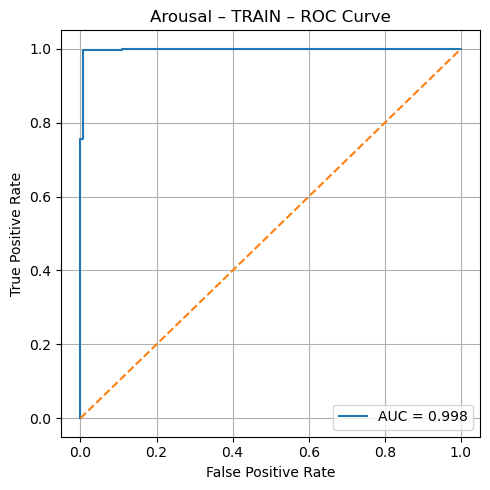

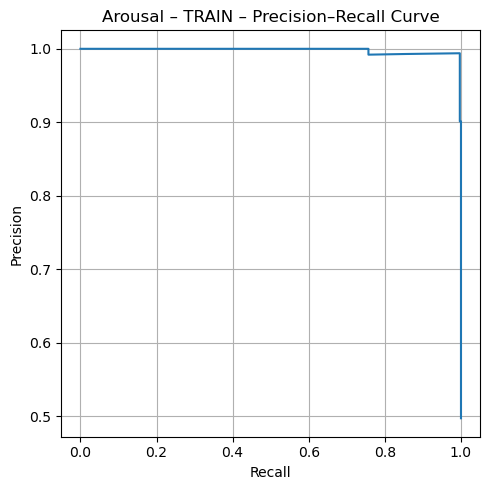

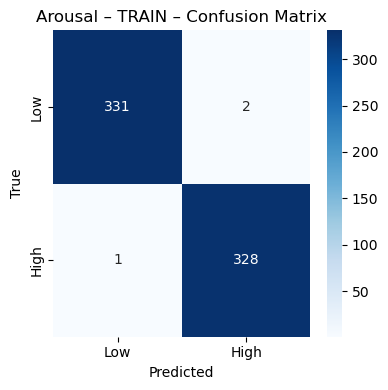


================ AROUSAL – VALIDATION =================
Samples        : 83
Precision      : 0.9524
Recall         : 1.0000
F1-score       : 0.9756
AUC            : 0.9797
Cohen's Kappa  : 0.9060


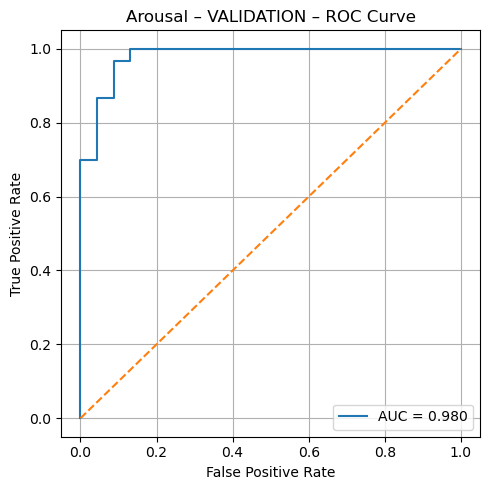

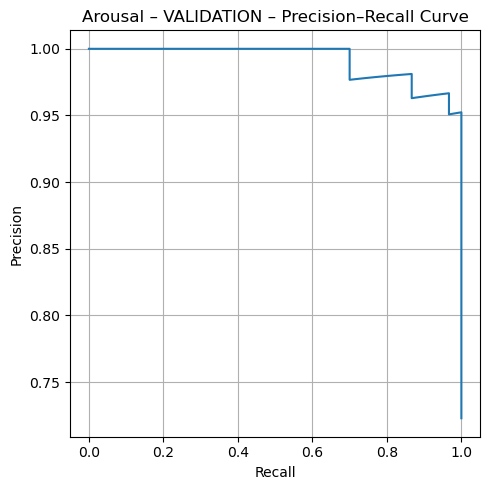

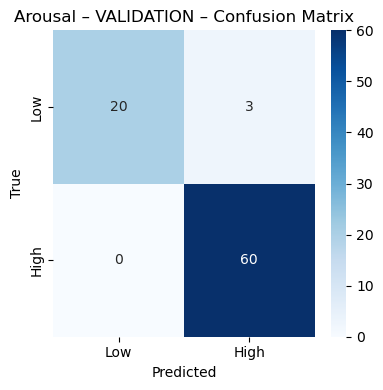


================ AROUSAL – TEST =================
Samples        : 83
Precision      : 0.9672
Recall         : 0.9833
F1-score       : 0.9752
AUC            : 0.9717
Cohen's Kappa  : 0.9086


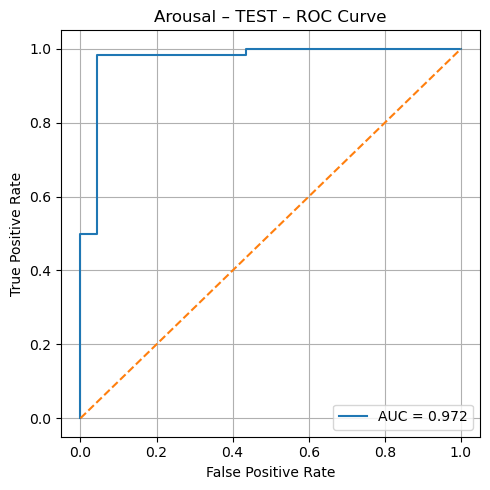

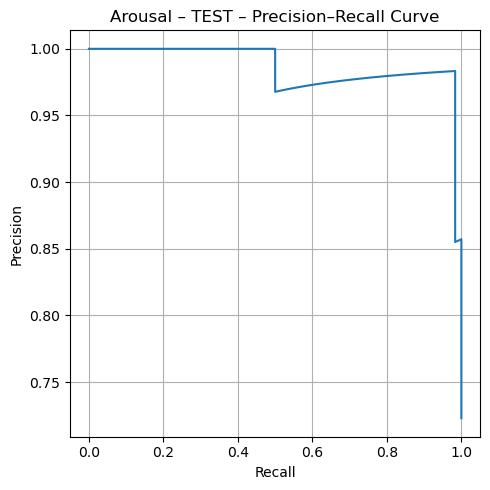

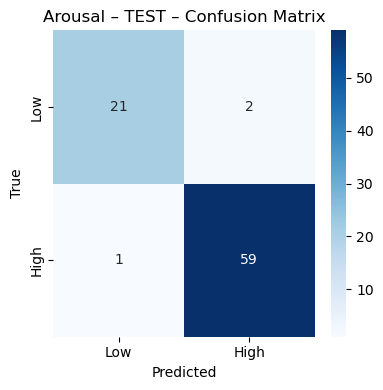

In [6]:
# ---------- Baseline-Aware Dual-Stream ConvNeXt Transformer on DREAMER ----------

import copy, random, time
import numpy as np
import scipy.io as sio
from scipy.signal import stft, resample

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    precision_recall_curve,
    cohen_kappa_score
)
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as Fnn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights

import matplotlib.pyplot as plt 

# ---------------- User config ----------------
DREAMER_PATH = r"C:\Users\akash\Downloads\DREAMER.mat" 
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32

# Valence training config
VAL_STAGE1_EPOCHS = 6
VAL_STAGE2_EPOCHS = 80
VAL_LEARNING_HEAD = 1e-3
VAL_LEARNING_FINE = 1e-4
VAL_WEIGHT_DECAY = 1e-4
VAL_EARLY_STOP_PATIENCE = 20

# Arousal training config
ARO_STAGE1_EPOCHS = 6
ARO_STAGE2_EPOCHS = 80
ARO_LEARNING_HEAD = 1e-3
ARO_LEARNING_FINE = 7e-5
ARO_WEIGHT_DECAY = 1e-4
ARO_EARLY_STOP_PATIENCE = 20

SEED_VAL = 52
SEED_ARO = 53

SEED = 42
FREQ_BINS = 36
TIME_BINS = 32
UPSAMP_SIZE = (96, 96)     # ConvNeXt-friendly size

print("Device:", DEVICE)

# ---------------- Loader: build baseline & stimulus spectrograms ----------------
def load_dreamer_dual_spectrograms(
    mat_path,
    fs=128,
    nperseg=256,
    noverlap=128,
    freq_max=45,
    time_bins=TIME_BINS,
    freq_bins=FREQ_BINS,
):
    """
    Builds two spectrogram tensors:
      X_base: (N, C, F, T) from baseline EEG
      X_stim: (N, C, F, T) from stimulus EEG
    labels: valence, arousal (continuous 1-5)
    """
    print(f"📂 Loading DREAMER dataset (dual spectrograms) from: {mat_path}")
    mat = sio.loadmat(mat_path, squeeze_me=True, struct_as_record=False)

    dreamer = None
    for k in ["DREAMER", "dreamer", "data", "DATA", "dataset"]:
        if k in mat:
            dreamer = mat[k]
            break
    if dreamer is None:
        for k, v in mat.items():
            if hasattr(v, "Data") or (isinstance(v, np.ndarray) and v.dtype == "O"):
                dreamer = v
                break
    if dreamer is None:
        raise RuntimeError("Couldn't find DREAMER struct in MAT file")

    data = getattr(dreamer, "Data", dreamer)

    Xb_list, Xs_list, y_val, y_aro, groups = [], [], [], [], []

    for subj_idx, subj in enumerate(np.atleast_1d(data)):
        # robust access to EEG
        eeg = None
        for nm in ("EEG", "eeg"):
            if isinstance(subj, dict) and nm in subj:
                eeg = subj[nm]
                break
            eeg = getattr(subj, nm, eeg)
        if eeg is None:
            continue

        # helper to find fields inside possibly-nested structs / dicts / arrays
        def get_field(obj, names):
            if obj is None:
                return None
            for n in names:
                try:
                    if isinstance(obj, dict) and n in obj:
                        return obj[n]
                    v = getattr(obj, n)
                    if v is not None:
                        return v
                except:
                    pass
            if isinstance(obj, np.ndarray) and obj.dtype == "O" and obj.size > 0:
                first = obj.flat[0]
                for n in names:
                    try:
                        if isinstance(first, dict) and n in first:
                            return first[n]
                        v = getattr(first, n)
                        if v is not None:
                            return v
                    except:
                        pass
            return None

        baseline = get_field(eeg, ["baseline", "Baseline"])
        stimuli = get_field(eeg, ["stimuli", "stimulus", "Stimuli"])
        if baseline is None or stimuli is None:
            continue

        val_scores = get_field(subj, ["ScoreValence", "valence", "Valence"])
        aro_scores = get_field(subj, ["ScoreArousal", "arousal", "Arousal"])
        if val_scores is None or aro_scores is None:
            continue

        # flatten scores robustly
        def flatten_scores(s):
            try:
                if isinstance(s, (list, tuple)):
                    return np.array(
                        [float(np.ravel(x)[0]) for x in s], dtype=float
                    )
                if isinstance(s, np.ndarray) and s.dtype == "O":
                    return np.array(
                        [float(np.ravel(x)[0]) for x in s], dtype=float
                    )
                return np.ravel(s).astype(float)
            except:
                return np.array([])

        scores_val = flatten_scores(val_scores)
        scores_aro = flatten_scores(aro_scores)
        if scores_val.size == 0 or scores_aro.size == 0:
            continue

        baseline_list = list(np.atleast_1d(baseline))
        stimuli_list = list(np.atleast_1d(stimuli))
        n_trials = min(len(stimuli_list), len(scores_val), len(scores_aro))

        for t in range(n_trials):
            try:
                base_sig = np.array(baseline_list[t], dtype=float)
                stim_sig = np.array(stimuli_list[t], dtype=float)
                if base_sig.ndim != 2 or stim_sig.ndim != 2:
                    continue

                ch_imgs_b = []
                ch_imgs_s = []

                for ch in range(stim_sig.shape[1]):
                    sig_b = base_sig[:, ch]
                    sig_s = stim_sig[:, ch]

                    f_b, _, Zb = stft(
                        sig_b, fs=fs, nperseg=nperseg, noverlap=noverlap
                    )
                    f_s, _, Zs = stft(
                        sig_s, fs=fs, nperseg=nperseg, noverlap=noverlap
                    )
                    Pb = np.abs(Zb) ** 2
                    Ps = np.abs(Zs) ** 2

                    mask_b = f_b <= freq_max
                    mask_s = f_s <= freq_max
                    Pb = Pb[mask_b, :]
                    Ps = Ps[mask_s, :]

                    # match time length
                    minT = min(Pb.shape[1], Ps.shape[1])
                    Pb = Pb[:, :minT]
                    Ps = Ps[:, :minT]

                    # log power
                    Pb = np.log(np.clip(Pb, 1e-12, None))
                    Ps = np.log(np.clip(Ps, 1e-12, None))

                    Pb = np.nan_to_num(Pb)
                    Ps = np.nan_to_num(Ps)

                    # resample to fixed bins
                    if Pb.shape[1] != TIME_BINS:
                        Pb = resample(Pb, TIME_BINS, axis=1)
                    if Pb.shape[0] != FREQ_BINS:
                        Pb = resample(Pb, FREQ_BINS, axis=0)

                    if Ps.shape[1] != TIME_BINS:
                        Ps = resample(Ps, TIME_BINS, axis=1)
                    if Ps.shape[0] != FREQ_BINS:
                        Ps = resample(Ps, FREQ_BINS, axis=0)

                    ch_imgs_b.append(Pb.astype(np.float32))
                    ch_imgs_s.append(Ps.astype(np.float32))

                Xb_list.append(np.stack(ch_imgs_b, axis=0))  # (C, F, T)
                Xs_list.append(np.stack(ch_imgs_s, axis=0))
                y_val.append(float(scores_val[t]))
                y_aro.append(float(scores_aro[t]))
                groups.append(subj_idx)
            except Exception as e:
                continue

    X_base = np.array(Xb_list, dtype=np.float32)
    X_stim = np.array(Xs_list, dtype=np.float32)
    y_val = np.array(y_val, dtype=float)
    y_aro = np.array(y_aro, dtype=float)
    groups = np.array(groups, dtype=int)
    print("✅ Built dual spectrogram dataset:", X_base.shape, X_stim.shape)
    return X_base, X_stim, y_val, y_aro


# ---------------- dataset & augment ----------------
class DualSpectrogramDataset(Dataset):
    def __init__(self, Xb, Xs, y):
        self.Xb = np.asarray(Xb, dtype=np.float32)
        self.Xs = np.asarray(Xs, dtype=np.float32)
        self.y = np.asarray(y, dtype=np.float32)

    def __len__(self):
        return len(self.Xb)

    def __getitem__(self, idx):
        return (
            torch.from_numpy(self.Xb[idx]).float(),
            torch.from_numpy(self.Xs[idx]).float(),
            torch.tensor(self.y[idx]).float(),
        )


def add_noise(X, std=0.05):
    noise = np.random.normal(0, std, X.shape).astype(np.float32)
    return np.clip(X + noise, -3.0, 3.0)


# ---------------- Baseline-Aware Dual-Stream ConvNeXt Transformer ----------------
class BaselineAwareConvNeXtTransformer(nn.Module):
    def __init__(
        self,
        in_channels=14,
        pretrained_backbone=True,
        d_model=256,
        nhead=8,
        num_layers=4,
        dim_feedforward=512,
        dropout=0.2,
    ):
        """
        Dual-stream architecture:
          - Shared ConvNeXt features for baseline & stimulus spectrograms
          - Feature-level delta fusion: [stim, stim-base]
          - Temporal transformer over time tokens
          - Classification head
        """
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 3, kernel_size=1),
        )

        weights = ConvNeXt_Tiny_Weights.IMAGENET1K_V1 if pretrained_backbone else None
        convnext = convnext_tiny(weights=weights)
        self.backbone_features = convnext.features

        # infer backbone channel dim and token length with dummy
        with torch.no_grad():
            dummy = torch.randn(1, 3, UPSAMP_SIZE[0], UPSAMP_SIZE[1])
            feat = self.backbone_features(dummy)
            backbone_ch = feat.shape[1]
            seq_len = feat.shape[3]  # W' acts as time tokens
        self.backbone_ch = backbone_ch
        self.seq_len = seq_len

        # delta fusion projection: [stim, stim-base] -> d_model
        self.token_proj = nn.Linear(2 * backbone_ch, d_model)

        # positional embedding
        self.pos_embed = nn.Parameter(
            torch.randn(1, seq_len, d_model) * 0.02
        )

        # transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # classification head
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 1),
        )

    def encode_stream(self, x):
        """
        x: (B, C, F, T)
        returns: seq (B, seq_len, backbone_ch)
        """
        x = self.stem(x)  # (B,3,F,T)
        x = Fnn.interpolate(
            x, size=UPSAMP_SIZE, mode="bilinear", align_corners=False
        )
        feat = self.backbone_features(x)  # (B, Cb, H', W')
        feat_seq = feat.mean(dim=2)  # pool freq -> (B, Cb, W')
        return feat_seq.permute(0, 2, 1).contiguous()  # (B, W', Cb)

    def forward(self, x_base, x_stim):
        # encode both streams
        base_seq = self.encode_stream(x_base)
        stim_seq = self.encode_stream(x_stim)

        # feature delta
        delta_seq = stim_seq - base_seq
        cat_seq = torch.cat([stim_seq, delta_seq], dim=-1)  # (B, W', 2*Cb)

        # project to d_model
        tokens = self.token_proj(cat_seq)  # (B, W', d_model)

        # position embedding (interpolate if needed)
        if tokens.shape[1] != self.pos_embed.shape[1]:
            pos = Fnn.interpolate(
                self.pos_embed.permute(0, 2, 1),
                size=tokens.shape[1],
                mode="linear",
                align_corners=False,
            ).permute(0, 2, 1)
        else:
            pos = self.pos_embed
        tokens = tokens + pos.to(tokens.device)

        # temporal transformer
        out = self.transformer(tokens)  # (B, W', d_model)

        # pool across time
        pooled = out.mean(dim=1)  # (B, d_model)
        logits = self.mlp_head(pooled).squeeze(-1)
        return logits


# ---------------- Valence training (80/10/10 inside each fold) ----------------
def train_baseline_aware_model_valence(
    Xb,
    Xs,
    y_cont,
    emotion_name="Valence",
    seed=SEED,
):
    print(f"\n--- Training Baseline Aware ConvNeXt Transformer for {emotion_name}")
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    # preprocess: joint standardisation of base + stim
    Xb = np.nan_to_num(Xb)
    Xs = np.nan_to_num(Xs)

    X_all = np.concatenate([Xb, Xs], axis=0)
    scaler = StandardScaler()
    X_all_flat = X_all.reshape(X_all.shape[0], -1)
    X_all_scaled = scaler.fit_transform(X_all_flat).reshape(X_all.shape)

    Xb_scaled = X_all_scaled[: Xb.shape[0]]
    Xs_scaled = X_all_scaled[Xb.shape[0] :]

    # stronger noise augmentation for valence
    Xb_aug = np.concatenate([Xb_scaled, add_noise(Xb_scaled, std=0.05)], axis=0)
    Xs_aug = np.concatenate([Xs_scaled, add_noise(Xs_scaled, std=0.05)], axis=0)
    y_aug = np.concatenate([y_cont, y_cont], axis=0)

    # ---------- 80% train, 10% val, 10% test ----------

    # 1) stratified split into 80% train, 20% temp
    global_thr = np.median(y_aug)
    y_aug_bin = (y_aug >= global_thr).astype(np.int32)

    Xb_tr, Xb_temp, Xs_tr, Xs_temp, y_tr_cont, y_temp_cont = train_test_split(
        Xb_aug,
        Xs_aug,
        y_aug,
        test_size=0.2,          # 20% temp
        random_state=seed,
        shuffle=True,
        stratify=y_aug_bin,
    )

    # 2) split 20% temp into 10% val + 10% test (50-50)
    temp_thr = np.median(y_temp_cont)
    y_temp_bin = (y_temp_cont >= temp_thr).astype(np.int32)

    Xb_val, Xb_te, Xs_val, Xs_te, y_val_cont, y_te_cont = train_test_split(
        Xb_temp,
        Xs_temp,
        y_temp_cont,
        test_size=0.5,          # half of 20% -> 10% of total
        random_state=seed,
        shuffle=True,
        stratify=y_temp_bin,
    )

    # label binarisation w.r.t train median
    thr = np.median(y_tr_cont)
    y_tr  = (y_tr_cont  >= thr).astype(np.float32)
    y_val = (y_val_cont >= thr).astype(np.float32)
    y_te  = (y_te_cont  >= thr).astype(np.float32)

    print(f"{emotion_name} TRAIN median threshold = {thr:.4f}")
    print(
        "Train class counts:",
        np.bincount(y_tr.astype(int)),
        "Val class counts:",
        np.bincount(y_val.astype(int)),
        "Test class counts:",
        np.bincount(y_te.astype(int)),
    )

    # WeightedRandomSampler to balance classes (VALENCE) on TRAIN only
    class_counts = np.bincount(y_tr.astype(int))
    class_weights = 1.0 / (class_counts + 1e-6)
    sample_weights = class_weights[y_tr.astype(int)]
    sample_weights = torch.from_numpy(sample_weights).float()
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True,
    )

    train_dataset = DualSpectrogramDataset(Xb_tr, Xs_tr, y_tr)
    val_dataset   = DualSpectrogramDataset(Xb_val, Xs_val, y_val)
    test_dataset  = DualSpectrogramDataset(Xb_te, Xs_te, y_te)

    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        sampler=sampler,
        num_workers=0,
        pin_memory=False,
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=max(8, BATCH_SIZE * 2),
        shuffle=False,
        num_workers=0,
        pin_memory=False,
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=max(8, BATCH_SIZE * 2),
        shuffle=False,
        num_workers=0,
        pin_memory=False,
    )

    model = BaselineAwareConvNeXtTransformer(
        in_channels=Xb.shape[1], pretrained_backbone=True
    ).to(DEVICE)

    # Stage1: freeze backbone_features + stem -> train head only
    for p in model.backbone_features.parameters():
        p.requires_grad = False
    for p in model.stem.parameters():
        p.requires_grad = False

    head_params = [p for p in model.parameters() if p.requires_grad]
    opt = optim.AdamW(head_params, lr=VAL_LEARNING_HEAD, weight_decay=VAL_WEIGHT_DECAY)
    criterion = nn.BCEWithLogitsLoss()

    for ep in range(1, VAL_STAGE1_EPOCHS + 1):
        model.train()
        tloss = 0.0
        n = 0
        for xb, xs, yb in train_loader:
            xb, xs, yb = xb.to(DEVICE), xs.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad()
            logits = model(xb, xs).view(-1)
            loss = criterion(logits, yb)
            loss.backward()
            opt.step()
            tloss += loss.item() * xb.size(0)
            n += xb.size(0)
        print(f"Stage1 Ep{ep}/{VAL_STAGE1_EPOCHS} loss {tloss / max(1, n):.4f}")

    # Stage2: unfreeze all and fine-tune
    for p in model.backbone_features.parameters():
        p.requires_grad = True
    for p in model.stem.parameters():
        p.requires_grad = True

    neg = int((y_tr == 0).sum())
    pos = int((y_tr == 1).sum())
    pos_weight = torch.tensor(
        [(neg / pos) if pos > 0 else 1.0], dtype=torch.float32
    ).to(DEVICE)
    criterion2 = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    opt2 = optim.AdamW(model.parameters(), lr=VAL_LEARNING_FINE, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(opt2, T_0=20)

    best_acc = 0.0
    best_state = None
    counter = 0

    for ep in range(1, VAL_STAGE2_EPOCHS + 1):
        model.train()
        tloss = 0.0
        n = 0
        for xb, xs, yb in train_loader:
            xb, xs, yb = xb.to(DEVICE), xs.to(DEVICE), yb.to(DEVICE)
            opt2.zero_grad()
            logits = model(xb, xs).view(-1)
            loss = criterion2(logits, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 3.0)
            opt2.step()
            tloss += loss.item() * xb.size(0)
            n += xb.size(0)
        scheduler.step()

        # ----- validation on 0.5 for monitoring -----
        model.eval()
        ys_val, ps_val = [], []
        with torch.no_grad():
            for xb, xs, yb in val_loader:
                xb, xs = xb.to(DEVICE), xs.to(DEVICE)
                p = torch.sigmoid(model(xb, xs)).cpu().numpy()
                ps_val.append(p)
                ys_val.append(yb.numpy())
        y_true_val = np.concatenate(ys_val)
        y_prob_val = np.concatenate(ps_val)
        y_pred_val = (y_prob_val >= 0.5).astype(int)

        acc = accuracy_score(y_true_val, y_pred_val)
        prec, rec, f1, _ = precision_recall_fscore_support(
            y_true_val, y_pred_val, average="binary", zero_division=0
        )
        try:
            auc = roc_auc_score(y_true_val, y_prob_val)
        except:
            auc = float("nan")
        print(
            f"Ep{ep}/{VAL_STAGE2_EPOCHS} | Loss={tloss/max(1,n):.4f} | "
            f"Val Acc={acc*100:.2f}% | Prec={prec:.3f} | Rec={rec:.3f} | "
            f"F1={f1:.3f} | AUC={auc:.3f}"
        )

        # early stopping based on **validation** accuracy
        if acc > best_acc:
            best_acc = acc
            best_state = copy.deepcopy(model.state_dict())
            counter = 0
        else:
            counter += 1
            if counter >= VAL_EARLY_STOP_PATIENCE and ep > 20:
                print("Early stopping")
                break

    # ---------- Final evaluation on TEST set with optimal threshold ----------
    if best_state is not None:
        model.load_state_dict(best_state)

    model.eval()
    ys_te, ps_te = [], []
    with torch.no_grad():
        for xb, xs, yb in test_loader:
            xb, xs = xb.to(DEVICE), xs.to(DEVICE)
            p = torch.sigmoid(model(xb, xs)).cpu().numpy()
            ps_te.append(p)
            ys_te.append(yb.numpy())
    y_true = np.concatenate(ys_te)
    y_prob = np.concatenate(ps_te)

    best_thr, best_thr_acc = 0.5, 0.0
    for thr_ in np.linspace(0.1, 0.9, 17):
        y_pred_thr = (y_prob >= thr_).astype(int)
        acc_thr = accuracy_score(y_true, y_pred_thr)
        if acc_thr > best_thr_acc:
            best_thr_acc = acc_thr
            best_thr = thr_

    y_pred_best = (y_prob >= best_thr).astype(int)

    print("\n=== FINAL METRICS (Valence, best threshold, TEST set) ===")
    print(f"Best threshold = {best_thr:.3f}")
    print("Accuracy:", accuracy_score(y_true, y_pred_best))
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred_best, average="binary", zero_division=0
    )
    try:
            print("AUC:", roc_auc_score(y_true, y_prob))
    except:
            print("AUC: nan")
    print("Confusion matrix:\n", confusion_matrix(y_true, y_pred_best))
    print(
        "\nClassification report:\n",
        classification_report(y_true, y_pred_best, digits=4),
    )
    # Note: y_true / y_prob are for TEST set
        # -------- FINAL Train & Val accuracy --------
    def compute_accuracy(loader):
        model.eval()
        ys, ps = [], []
        with torch.no_grad():
            for xb, xs, yb in loader:
                xb, xs = xb.to(DEVICE), xs.to(DEVICE)
                p = torch.sigmoid(model(xb, xs)).cpu().numpy()
                ps.append(p)
                ys.append(yb.numpy())
        y_true = np.concatenate(ys)
        y_pred = (np.concatenate(ps) >= 0.5).astype(int)
        return accuracy_score(y_true, y_pred)

    train_acc = compute_accuracy(train_loader)
    val_acc   = compute_accuracy(val_loader)
    test_acc  = accuracy_score(y_true, y_pred_best)

    print(f"\nFINAL ACCURACY SUMMARY (VALENCE)")
    print(f"Train Accuracy : {train_acc:.4f}")
    print(f"Val Accuracy   : {val_acc:.4f}")
    print(f"Test Accuracy  : {test_acc:.4f}")

    return (
        model,
        y_true,
        y_prob,
        train_loader,
        val_loader,
        test_loader,
    )




# ---------------- Arousal training (80/10/10 inside each fold) ----------------
def train_baseline_aware_model_arousal(
    Xb,
    Xs,
    y_cont,
    emotion_name="Arousal",
    seed=SEED+1,
):
    print(f"\n--- Training Baseline Aware ConvNeXt Transformer for {emotion_name} (AROUSAL)")
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    # ----------- 1) Preprocess & joint standardisation -----------
    Xb = np.nan_to_num(Xb)
    Xs = np.nan_to_num(Xs)

    X_all = np.concatenate([Xb, Xs], axis=0)
    scaler = StandardScaler()
    X_all_flat = X_all.reshape(X_all.shape[0], -1)
    X_all_scaled = scaler.fit_transform(X_all_flat).reshape(X_all.shape)

    Xb_scaled = X_all_scaled[: Xb.shape[0]]
    Xs_scaled = X_all_scaled[Xb.shape[0] :]

    # ----------- 2) Stronger augmentation for arousal -----------
    Xb_aug = np.concatenate([Xb_scaled, add_noise(Xb_scaled, std=0.05)], axis=0)
    Xs_aug = np.concatenate([Xs_scaled, add_noise(Xs_scaled, std=0.05)], axis=0)
    y_aug  = np.concatenate([y_cont, y_cont], axis=0)

    # ----------- 3) 80% train, 10% val, 10% test -----------

    # First: 80% train, 20% temp
    global_thr = np.median(y_aug)
    y_aug_bin = (y_aug >= global_thr).astype(np.int32)

    Xb_tr, Xb_temp, Xs_tr, Xs_temp, y_tr_cont, y_temp_cont = train_test_split(
        Xb_aug,
        Xs_aug,
        y_aug,
        test_size=0.2,
        random_state=seed,
        shuffle=True,
        stratify=y_aug_bin,
    )

    # Then: split temp into 10% val + 10% test
    temp_thr = np.median(y_temp_cont)
    y_temp_bin = (y_temp_cont >= temp_thr).astype(np.int32)

    Xb_val, Xb_te, Xs_val, Xs_te, y_val_cont, y_te_cont = train_test_split(
        Xb_temp,
        Xs_temp,
        y_temp_cont,
        test_size=0.5,
        random_state=seed,
        shuffle=True,
        stratify=y_temp_bin,
    )

    # Label binarisation w.r.t train median
    thr = np.median(y_tr_cont)
    y_tr  = (y_tr_cont  >= thr).astype(np.float32)
    y_val = (y_val_cont >= thr).astype(np.float32)
    y_te  = (y_te_cont  >= thr).astype(np.float32)

    print(f"{emotion_name} TRAIN median threshold = {thr:.4f}")
    print(
        "Train class counts:",
        np.bincount(y_tr.astype(int)),
        "Val class counts:",
        np.bincount(y_val.astype(int)),
        "Test class counts:",
        np.bincount(y_te.astype(int)),
    )

    # ----------- 4) Dataset + **WeightedRandomSampler** (train only) -----------
    train_dataset = DualSpectrogramDataset(Xb_tr, Xs_tr, y_tr)
    val_dataset   = DualSpectrogramDataset(Xb_val, Xs_val, y_val)
    test_dataset  = DualSpectrogramDataset(Xb_te, Xs_te, y_te)

    class_counts = np.bincount(y_tr.astype(int))
    class_weights = 1.0 / (class_counts + 1e-6)
    sample_weights = class_weights[y_tr.astype(int)]
    sample_weights = torch.from_numpy(sample_weights).float()

    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True,
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        sampler=sampler,
        num_workers=0,
        pin_memory=False,
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=max(8, BATCH_SIZE * 2),
        shuffle=False,
        num_workers=0,
        pin_memory=False,
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=max(8, BATCH_SIZE * 2),
        shuffle=False,
        num_workers=0,
        pin_memory=False,
    )

    # ----------- 5) Model -----------
    model = BaselineAwareConvNeXtTransformer(
        in_channels=Xb.shape[1],
        pretrained_backbone=True,
    ).to(DEVICE)

    # ----------- 6) Stage1: freeze backbone, train head -----------
    for p in model.backbone_features.parameters():
        p.requires_grad = False
    for p in model.stem.parameters():
        p.requires_grad = False

    head_params = [p for p in model.parameters() if p.requires_grad]
    opt = optim.AdamW(head_params, lr=ARO_LEARNING_HEAD, weight_decay=ARO_WEIGHT_DECAY)
    criterion = nn.BCEWithLogitsLoss()

    for ep in range(1, ARO_STAGE1_EPOCHS + 1):
        model.train()
        tloss = 0.0
        n = 0
        for xb, xs, yb in train_loader:
            xb, xs, yb = xb.to(DEVICE), xs.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad()
            logits = model(xb, xs).view(-1)
            loss = criterion(logits, yb)
            loss.backward()
            opt.step()
            tloss += loss.item() * xb.size(0)
            n += xb.size(0)
        print(f"Stage1 Ep{ep}/{ARO_STAGE1_EPOCHS} loss {tloss / max(1, n):.4f}")

    # ----------- 7) Stage2: unfreeze all & fine-tune -----------
    for p in model.backbone_features.parameters():
        p.requires_grad = True
    for p in model.stem.parameters():
        p.requires_grad = True

    neg = int((y_tr == 0).sum())
    pos = int((y_tr == 1).sum())
    pos_weight = torch.tensor(
        [(neg / pos) if pos > 0 else 1.0], dtype=torch.float32
    ).to(DEVICE)
    criterion2 = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    opt2 = optim.AdamW(model.parameters(), lr=ARO_LEARNING_FINE, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(opt2, T_0=20)

    best_acc = 0.0
    best_state = None
    counter = 0

    for ep in range(1, ARO_STAGE2_EPOCHS + 1):
        model.train()
        tloss = 0.0
        n = 0
        for xb, xs, yb in train_loader:
            xb, xs, yb = xb.to(DEVICE), xs.to(DEVICE), yb.to(DEVICE)
            opt2.zero_grad()
            logits = model(xb, xs).view(-1)
            loss = criterion2(logits, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 3.0)
            opt2.step()
            tloss += loss.item() * xb.size(0)
            n += xb.size(0)
        scheduler.step()

        # -------- validation on 0.5 for monitoring --------
        model.eval()
        ys_val, ps_val = [], []
        with torch.no_grad():
            for xb, xs, yb in val_loader:
                xb, xs = xb.to(DEVICE), xs.to(DEVICE)
                p = torch.sigmoid(model(xb, xs)).cpu().numpy()
                ps_val.append(p)
                ys_val.append(yb.numpy())
        y_true_val = np.concatenate(ys_val)
        y_prob_val = np.concatenate(ps_val)
        y_pred_val = (y_prob_val >= 0.5).astype(int)

        acc = accuracy_score(y_true_val, y_pred_val)
        prec, rec, f1, _ = precision_recall_fscore_support(
            y_true_val, y_pred_val, average="binary", zero_division=0
        )
        try:
            auc = roc_auc_score(y_true_val, y_prob_val)
        except:
            auc = float("nan")
        print(
            f"Ep{ep}/{ARO_STAGE2_EPOCHS} | Loss={tloss/max(1,n):.4f} | "
            f"Val Acc={acc*100:.2f}% | Prec={prec:.3f} | Rec={rec:.3f} | "
            f"F1={f1:.3f} | AUC={auc:.3f}"
        )

        if acc > best_acc:
            best_acc = acc
            best_state = copy.deepcopy(model.state_dict())
            counter = 0
        else:
            counter += 1
            if counter >= ARO_EARLY_STOP_PATIENCE and ep > 20:
                print("Early stopping")
                break

    # ----------- 8) Load best & FINAL TEST evaluation + threshold search -----------
    if best_state is not None:
        model.load_state_dict(best_state)

    model.eval()
    ys_te, ps_te = [], []
    with torch.no_grad():
        for xb, xs, yb in test_loader:
            xb, xs = xb.to(DEVICE), xs.to(DEVICE)
            p = torch.sigmoid(model(xb, xs)).cpu().numpy()
            ps_te.append(p)
            ys_te.append(yb.numpy())
    y_true = np.concatenate(ys_te)
    y_prob = np.concatenate(ps_te)

    best_thr, best_thr_acc = 0.5, 0.0
    for thr_ in np.linspace(0.1, 0.9, 17):
        y_pred_thr = (y_prob >= thr_).astype(int)
        acc_thr = accuracy_score(y_true, y_pred_thr)
        if acc_thr > best_thr_acc:
            best_thr_acc = acc_thr
            best_thr = thr_

    y_pred_best = (y_prob >= best_thr).astype(int)

    print("\n=== FINAL METRICS (Arousal, best threshold, TEST set) ===")
    print(f"Best threshold = {best_thr:.3f}")
    print("Accuracy:", accuracy_score(y_true, y_pred_best))
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred_best, average="binary", zero_division=0
    )
    try:
        print("AUC:", roc_auc_score(y_true, y_prob))
    except:
        print("AUC: nan")
    print("Confusion matrix:\n", confusion_matrix(y_true, y_pred_best))
    print(
        "\nClassification report:\n",
        classification_report(y_true, y_pred_best, digits=4),
    )
    # Note: y_true / y_prob are for TEST set
        # -------- FINAL Train & Val accuracy --------
    def compute_accuracy(loader):
        model.eval()
        ys, ps = [], []
        with torch.no_grad():
            for xb, xs, yb in loader:
                xb, xs = xb.to(DEVICE), xs.to(DEVICE)
                p = torch.sigmoid(model(xb, xs)).cpu().numpy()
                ps.append(p)
                ys.append(yb.numpy())
        y_true = np.concatenate(ys)
        y_pred = (np.concatenate(ps) >= 0.5).astype(int)
        return accuracy_score(y_true, y_pred)

    train_acc = compute_accuracy(train_loader)
    val_acc   = compute_accuracy(val_loader)
    test_acc  = accuracy_score(y_true, y_pred_best)

    print(f"\nFINAL ACCURACY SUMMARY (AROUSAL)")
    print(f"Train Accuracy : {train_acc:.4f}")
    print(f"Val Accuracy   : {val_acc:.4f}")
    print(f"Test Accuracy  : {test_acc:.4f}")

    return (
        model,
        y_true,
        y_prob,
        train_loader,
        val_loader,
        test_loader,
    )


def evaluate_and_plot(loader, model, title):
    model.eval()
    ys, ps = [], []

    with torch.no_grad():
        for xb, xs, yb in loader:
            xb, xs = xb.to(DEVICE), xs.to(DEVICE)
            p = torch.sigmoid(model(xb, xs)).cpu().numpy()
            ps.append(p)
            ys.append(yb.numpy())

    y_true = np.concatenate(ys)
    y_prob = np.concatenate(ps)
    y_pred = (y_prob >= 0.5).astype(int)

    # ---------- Metrics ----------
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", zero_division=0
    )
    auc = roc_auc_score(y_true, y_prob)
    kappa = cohen_kappa_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    print(f"\n================ {title.upper()} =================")
    print(f"Samples        : {len(y_true)}")
    print(f"Precision      : {precision:.4f}")
    print(f"Recall         : {recall:.4f}")
    print(f"F1-score       : {f1:.4f}")
    print(f"AUC            : {auc:.4f}")
    print(f"Cohen's Kappa  : {kappa:.4f}")

    # ---------- ROC Curve ----------
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{title} – ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # ---------- Precision–Recall Curve ----------
    pr, rc, _ = precision_recall_curve(y_true, y_prob)
    plt.figure(figsize=(5, 5))
    plt.plot(rc, pr)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"{title} – Precision–Recall Curve")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # ---------- Confusion Matrix ----------
    plt.figure(figsize=(4, 4))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues",
        xticklabels=["Low", "High"],
        yticklabels=["Low", "High"]
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"{title} – Confusion Matrix")
    plt.tight_layout()
    plt.show()


# ===============================================================
# ======================= SINGLE FOLD RUN =======================
# ===============================================================
if __name__ == "__main__":

    Xb, Xs, y_val, y_aro = load_dreamer_dual_spectrograms(DREAMER_PATH)

    # ===================== VALENCE =====================
    model_val, y_true_val, y_prob_val, train_ld_v, val_ld_v, test_ld_v = \
    train_baseline_aware_model_valence(
        Xb, Xs, y_val,
        emotion_name="Valence (Single Fold)",
        seed=SEED_VAL
    )



    evaluate_and_plot(train_ld_v, model_val, "Valence – TRAIN")
    evaluate_and_plot(val_ld_v,   model_val, "Valence – VALIDATION")
    evaluate_and_plot(test_ld_v,  model_val, "Valence – TEST")

    # ===================== AROUSAL =====================
    model_aro, y_true_aro, y_prob_aro, train_ld_a, val_ld_a, test_ld_a = \
    train_baseline_aware_model_arousal(
        Xb, Xs, y_aro,
        emotion_name="Arousal (Single Fold)",
        seed=SEED_ARO
    )



    evaluate_and_plot(train_ld_a, model_aro, "Arousal – TRAIN")
    evaluate_and_plot(val_ld_a,   model_aro, "Arousal – VALIDATION")
    evaluate_and_plot(test_ld_a,  model_aro, "Arousal – TEST")